In [1]:
import os, sys

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
CORE_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))), "core"
)
CORE_DIR_2 = os.path.join(
    os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))), "core/"
)
sys.path.append(os.path.dirname(CORE_DIR))
sys.path.append(os.path.dirname(CORE_DIR_2))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

import numpy as np
import argparse
from time import time
from loguru import logger
import matplotlib.pyplot as plt
import tifffile

from model import get_model
from utils.utils import load_json
from utils.data_utils import get_data, normalize_imgs, denormalize_imgs
from utils.torch_utils import setup_DDP, load_ckpt
from utils.nn_utils import flow_warp

2024-05-07 14:51:59.418034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 14:52:01.335761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
@torch.inference_mode
def run_model(imgs, cfg, model, is_ddp, metadata, test_aug):
    with autocast(enabled=cfg.train.mixed_precision):
        if is_ddp:
            rec = model.module.inference(imgs, metadata, test_aug=test_aug)
        else:
            rec = model.inference(imgs, metadata, test_aug=test_aug)

    return rec.squeeze().cpu().detach().numpy()


def sigma_bounds(image, sigma=2):
    mean = np.mean(image)
    std = np.std(image)

    lower_value = mean - sigma * std
    upper_value = mean + sigma * std

    return lower_value, upper_value


def fft(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.fftshift(x)))

In [19]:
seed = 1234


# config = '../../configs/nova/rotacell_grid1_TS09_ctf_6xBin_train.json'
# coords = [214,440,407]
# patch_shape = [32,128,128]

# config = '../../configs/nova/rotacell_grid1_TS09_ctf_6xBin_train.json'
# coords = [220-32,400,260]
# patch_shape = [64,160,160]

# config = '../../configs/nova/rotacell_grid1_TS09_ctf_3xBin_train.json'
# coords = [368-16,1160,330]
# patch_shape = [32,256,256]

config = "../../configs/nova/rotacell_grid1_TS09_ctf_3xBin_train.json"
coords = [551 - 32, 1026, 758]
patch_shape = [64, 128, 128]

In [20]:
world_size, rank, device = setup_DDP(seed)
is_ddp = world_size > 1

cfg = load_json(config)

data, metadata = get_data(cfg.data_path[0])
y_shape = metadata["shape"][1]

crop = np.asarray(
    data[
        coords[0] : coords[0] + patch_shape[0],
        y_shape - (coords[1] + patch_shape[1]) : y_shape - coords[1],
        coords[2] : coords[2] + patch_shape[2],
    ]
)

load_ckpt_path = os.path.join(cfg.train_dir, "last.pt")
model = get_model(cfg, device, is_ddp, compile=False)
model = load_ckpt(load_ckpt_path, model, is_ddp=is_ddp, compile=False)[0]
model.eval();

# Fig. 1A)

In [21]:
middle = 32
zs = [-15, -10, -5, 0, 5, 10, 15]
gap = 12
triplets = [crop[middle + i - gap : middle + i + gap + 1] for i in zs]

In [31]:
recs = []
for imgs in triplets:
    imgs = torch.from_numpy(imgs.copy()).float().unsqueeze(0).to(device)
    imgs = normalize_imgs(imgs, params=metadata)
    imgs_split = torch.split(imgs, 1, dim=1)

    rec_gaps = []
    for t in range(1, gap + 1):
        img0, imgT, img1 = (
            imgs_split[gap - t].contiguous(),
            imgs_split[gap].contiguous(),
            imgs_split[gap + t].contiguous(),
        )

        with torch.inference_mode():
            rec = model(img0, imgT, img1, TTA=True, mode="inference")
        rec_gaps.append(rec)
    rec = torch.cat(rec_gaps, dim=1).mean(dim=1, keepdim=True)
    rec = denormalize_imgs(rec, params=metadata)

    rec = rec.squeeze().cpu().detach().numpy()
    recs.append(rec)
recs = np.asarray(recs)

In [32]:
recs.shape

(7, 128, 128)

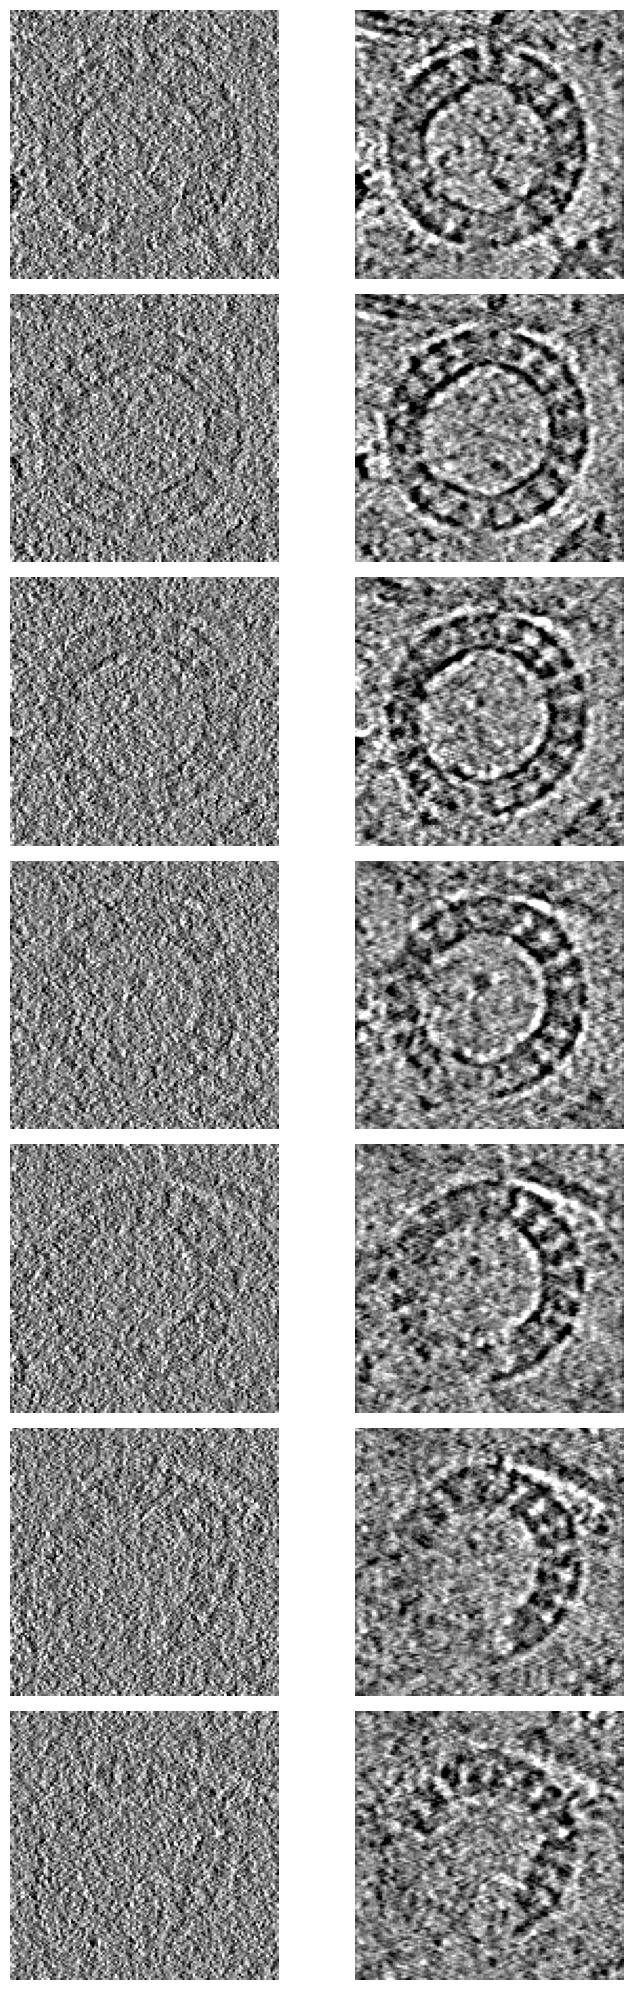

In [33]:
sigma = 2
vmin, vmax = sigma_bounds(crop, sigma=sigma)
vmin_r, vmax_r = sigma_bounds(
    np.repeat(recs, crop.shape[0] // recs.shape[0]), sigma=sigma
)

denoised = recs.mean(axis=0)
vmin_d, vmax_d = sigma_bounds(np.repeat(denoised, crop.shape[0]), sigma=sigma)

plt.figure(figsize=(8, 20))
for i in range(len(triplets)):
    rec, imgs = recs[i], triplets[i]
    plt.subplot(len(triplets), 2, 2 * i + 1)
    plt.imshow(imgs[gap], cmap="grey", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.subplot(len(triplets), 2, 2 * i + 2)
    plt.imshow(rec, cmap="grey", vmin=vmin_r, vmax=vmax_r)
    plt.axis("off")
plt.tight_layout()
# plt.savefig('fig1_A.svg', format='svg')
plt.show()

# Fig. 1B)

In [34]:
middle = 32
gap = 3
triplet = np.stack((crop[middle - gap], crop[middle], crop[middle + gap]), axis=0)

In [35]:
imgs = torch.from_numpy(triplet.copy()).float().unsqueeze(0).to(device)
imgs = normalize_imgs(imgs, params=metadata)
img0, imgT, img1 = torch.split(imgs, 1, dim=1)

with torch.inference_mode():
    rec = model.forward_once(img0, img1)

rec = denormalize_imgs(rec, params=metadata)
rec = rec.squeeze().cpu().detach().numpy()

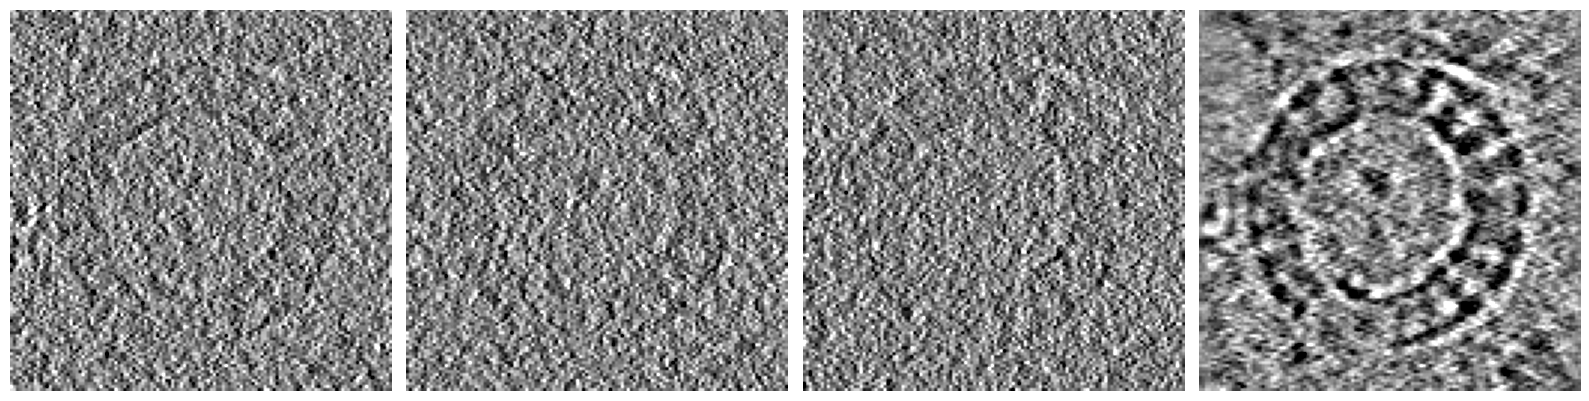

In [36]:
sigma = 2
vmin, vmax = sigma_bounds(crop, sigma=sigma)
vmin_r, vmax_r = sigma_bounds(np.repeat(rec, crop.shape[0]), sigma=sigma)

plt.figure(figsize=(16, 10))
plt.subplot(1, 4, 1)
plt.imshow(triplet[0], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(triplet[1], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(triplet[2], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(rec, cmap="grey", vmin=vmin_r, vmax=vmax_r)
plt.axis("off")
plt.tight_layout()
# plt.savefig('fig1_B.svg', format='svg')
plt.show()

# Fig. 1C)

In [37]:
middle = 32
gap = 3
triplet = np.stack((crop[middle - gap], crop[middle], crop[middle + gap]), axis=0)

In [38]:
imgs_unnorm = torch.from_numpy(triplet.copy()).float().unsqueeze(0).to(device)
imgs = normalize_imgs(imgs_unnorm, params=metadata)
img0, imgT, img1 = torch.split(imgs, 1, dim=1)

with torch.inference_mode():
    rec_minus = model.forward_once(img0, imgT)
    rec_plus = model.forward_once(imgT, img1)
    rec = model.forward_once(rec_minus, rec_plus)

rec_minus = (
    denormalize_imgs(rec_minus, params=metadata).squeeze().cpu().detach().numpy()
)
rec_plus = denormalize_imgs(rec_plus, params=metadata).squeeze().cpu().detach().numpy()
rec = denormalize_imgs(rec, params=metadata)
rec = rec.squeeze().cpu().detach().numpy()

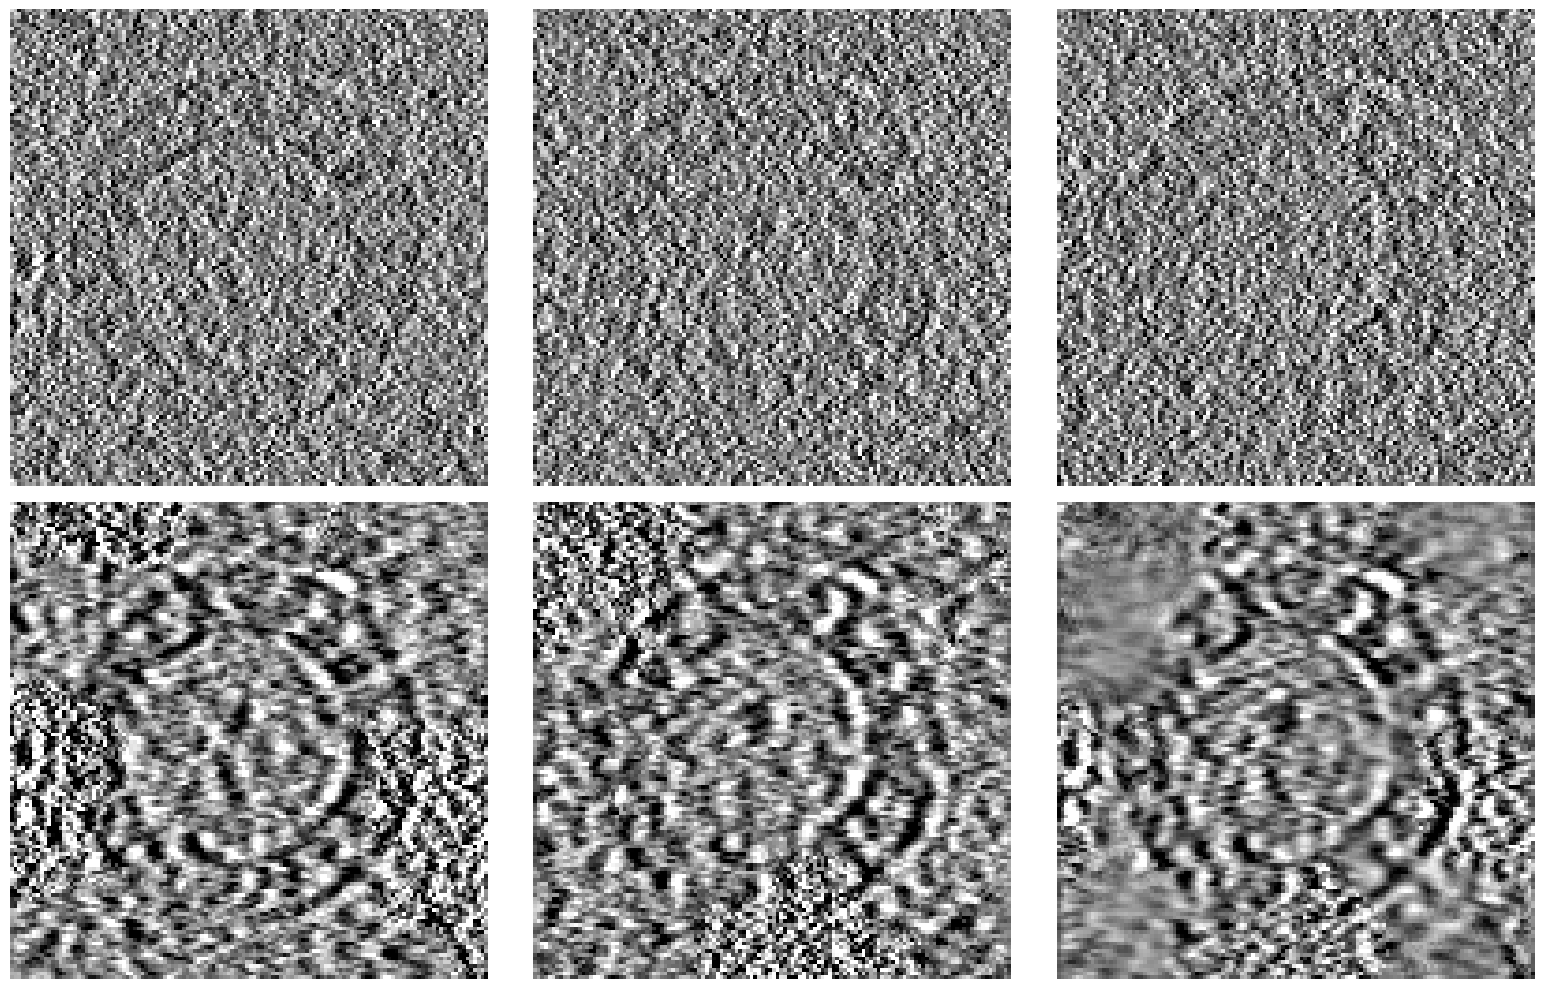

In [39]:
sigma = 2
vmin, vmax = sigma_bounds(crop, sigma=sigma)
vmin_r, vmax_r = sigma_bounds(np.repeat(rec, crop.shape[0]), sigma=sigma)

plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plt.imshow(triplet[0], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(triplet[1], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(triplet[2], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 4)
plt.imshow(rec_minus, cmap="grey", vmin=vmin_r, vmax=vmax_r)
plt.axis("off")
plt.subplot(2, 3, 5)
plt.imshow(rec_plus, cmap="grey", vmin=vmin_r, vmax=vmax_r)
plt.axis("off")
plt.subplot(2, 3, 6)
plt.imshow(rec, cmap="grey", vmin=vmin_r, vmax=vmax_r)
plt.axis("off")
plt.tight_layout()
# plt.savefig('fig1_C.svg', format='svg')
plt.show()

# Fig. 1D)

In [40]:
middle = 32
gap = 3
triplet = np.stack((crop[middle - gap], crop[middle], crop[middle + gap]), axis=0)

In [41]:
imgs = torch.from_numpy(triplet.copy()).float().unsqueeze(0).to(device)
imgs = normalize_imgs(imgs, params=metadata)
img0, imgT, img1 = torch.split(imgs, 1, dim=1)

with torch.inference_mode():
    biflow = model.biflownet(img0, img1)

    flow_0t = biflow[:, :2] * 0.5
    flow_1t = biflow[:, 2:4] * 0.5
    warped_img0 = flow_warp(img0, flow_0t)
    warped_img1 = flow_warp(img1, flow_1t)

    rec = model.forward_once(img0, img1)

rec = denormalize_imgs(rec, params=metadata).squeeze().cpu().detach().numpy()
warped_img0 = (
    denormalize_imgs(warped_img0, params=metadata).squeeze().cpu().detach().numpy()
)
warped_img1 = (
    denormalize_imgs(warped_img1, params=metadata).squeeze().cpu().detach().numpy()
)

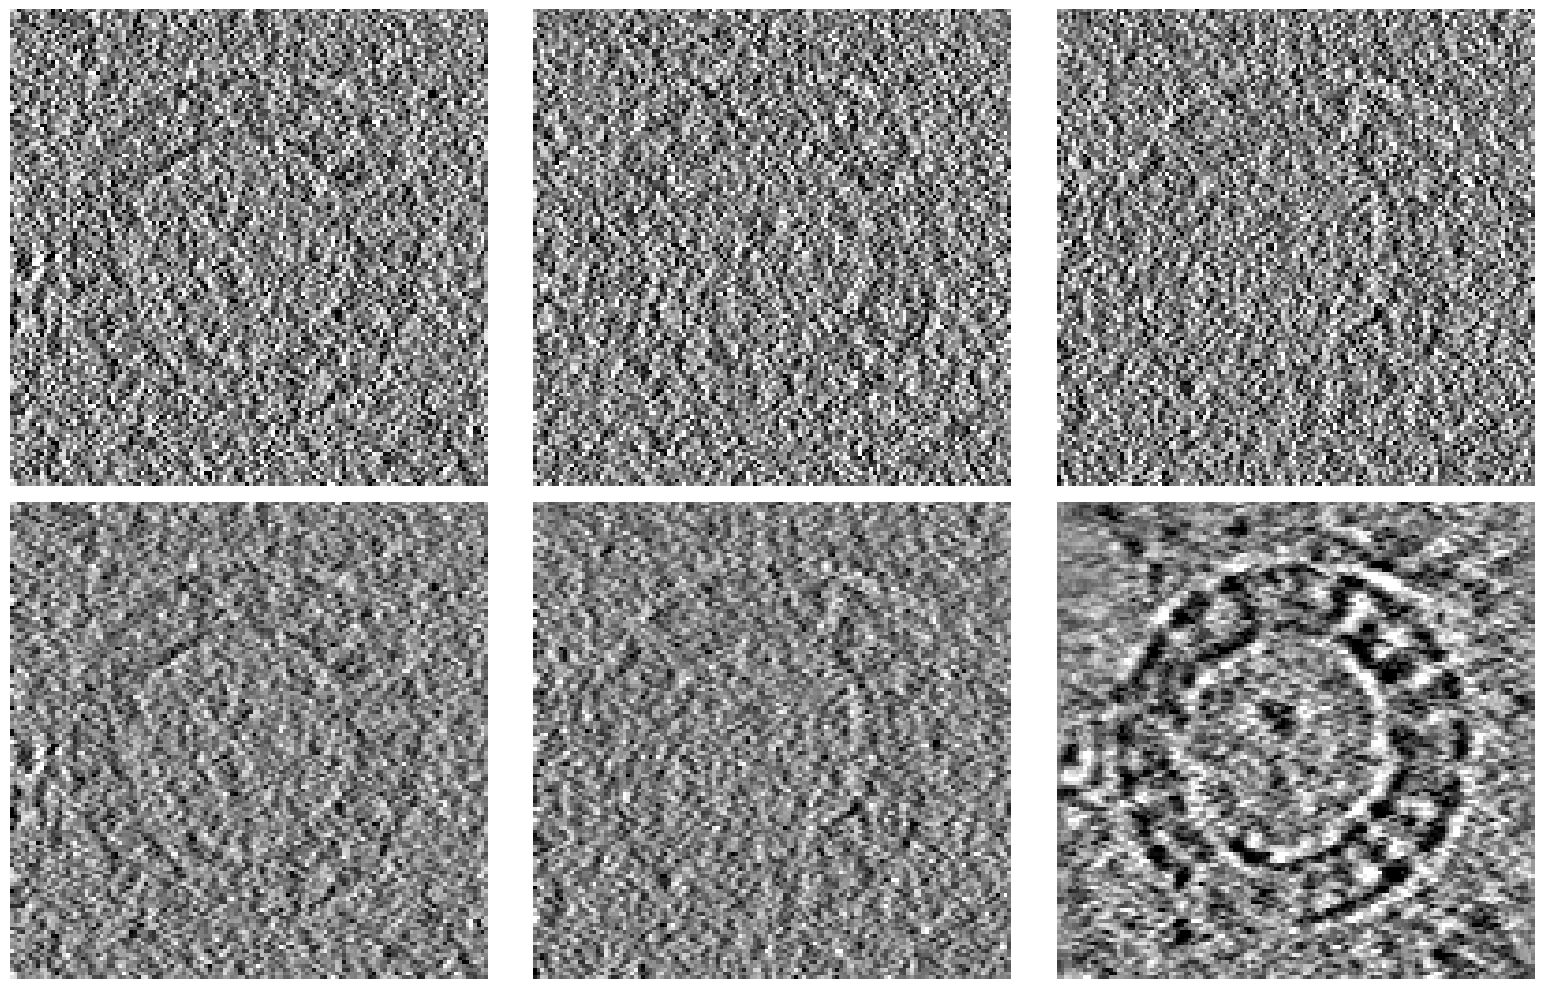

In [42]:
sigma = 2
vmin, vmax = sigma_bounds(crop, sigma=sigma)
vmin_r, vmax_r = sigma_bounds(np.repeat(rec, crop.shape[0]), sigma=sigma)

plt.figure(figsize=(16, 10))
plt.subplot(2, 3, 1)
plt.imshow(triplet[0], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(triplet[1], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(triplet[2], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 4)
plt.imshow(warped_img0, cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 5)
plt.imshow(warped_img1, cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(2, 3, 6)
plt.imshow(rec, cmap="grey", vmin=vmin_r, vmax=vmax_r)
plt.axis("off")
plt.tight_layout()
# plt.savefig('fig1_D.svg', format='svg')
plt.show()

# Fig. 1E)

In [43]:
middle = 32
gaps = [2, 4, 6]
triplets = [
    np.stack((crop[middle - gap], crop[middle], crop[middle + gap]), axis=0)
    for gap in gaps
]

In [44]:
recs = []
for imgs in triplets:
    imgs = torch.from_numpy(imgs.copy()).float().unsqueeze(0).to(device)
    imgs = normalize_imgs(imgs, params=metadata)
    img0, imgT, img1 = torch.split(imgs, 1, dim=1)

    with torch.inference_mode():
        rec = model.samba(img0, imgT, img1)

    rec = denormalize_imgs(rec, params=metadata)
    rec = rec.squeeze().cpu().detach().numpy()
    recs.append(rec)
recs = np.asarray(recs)

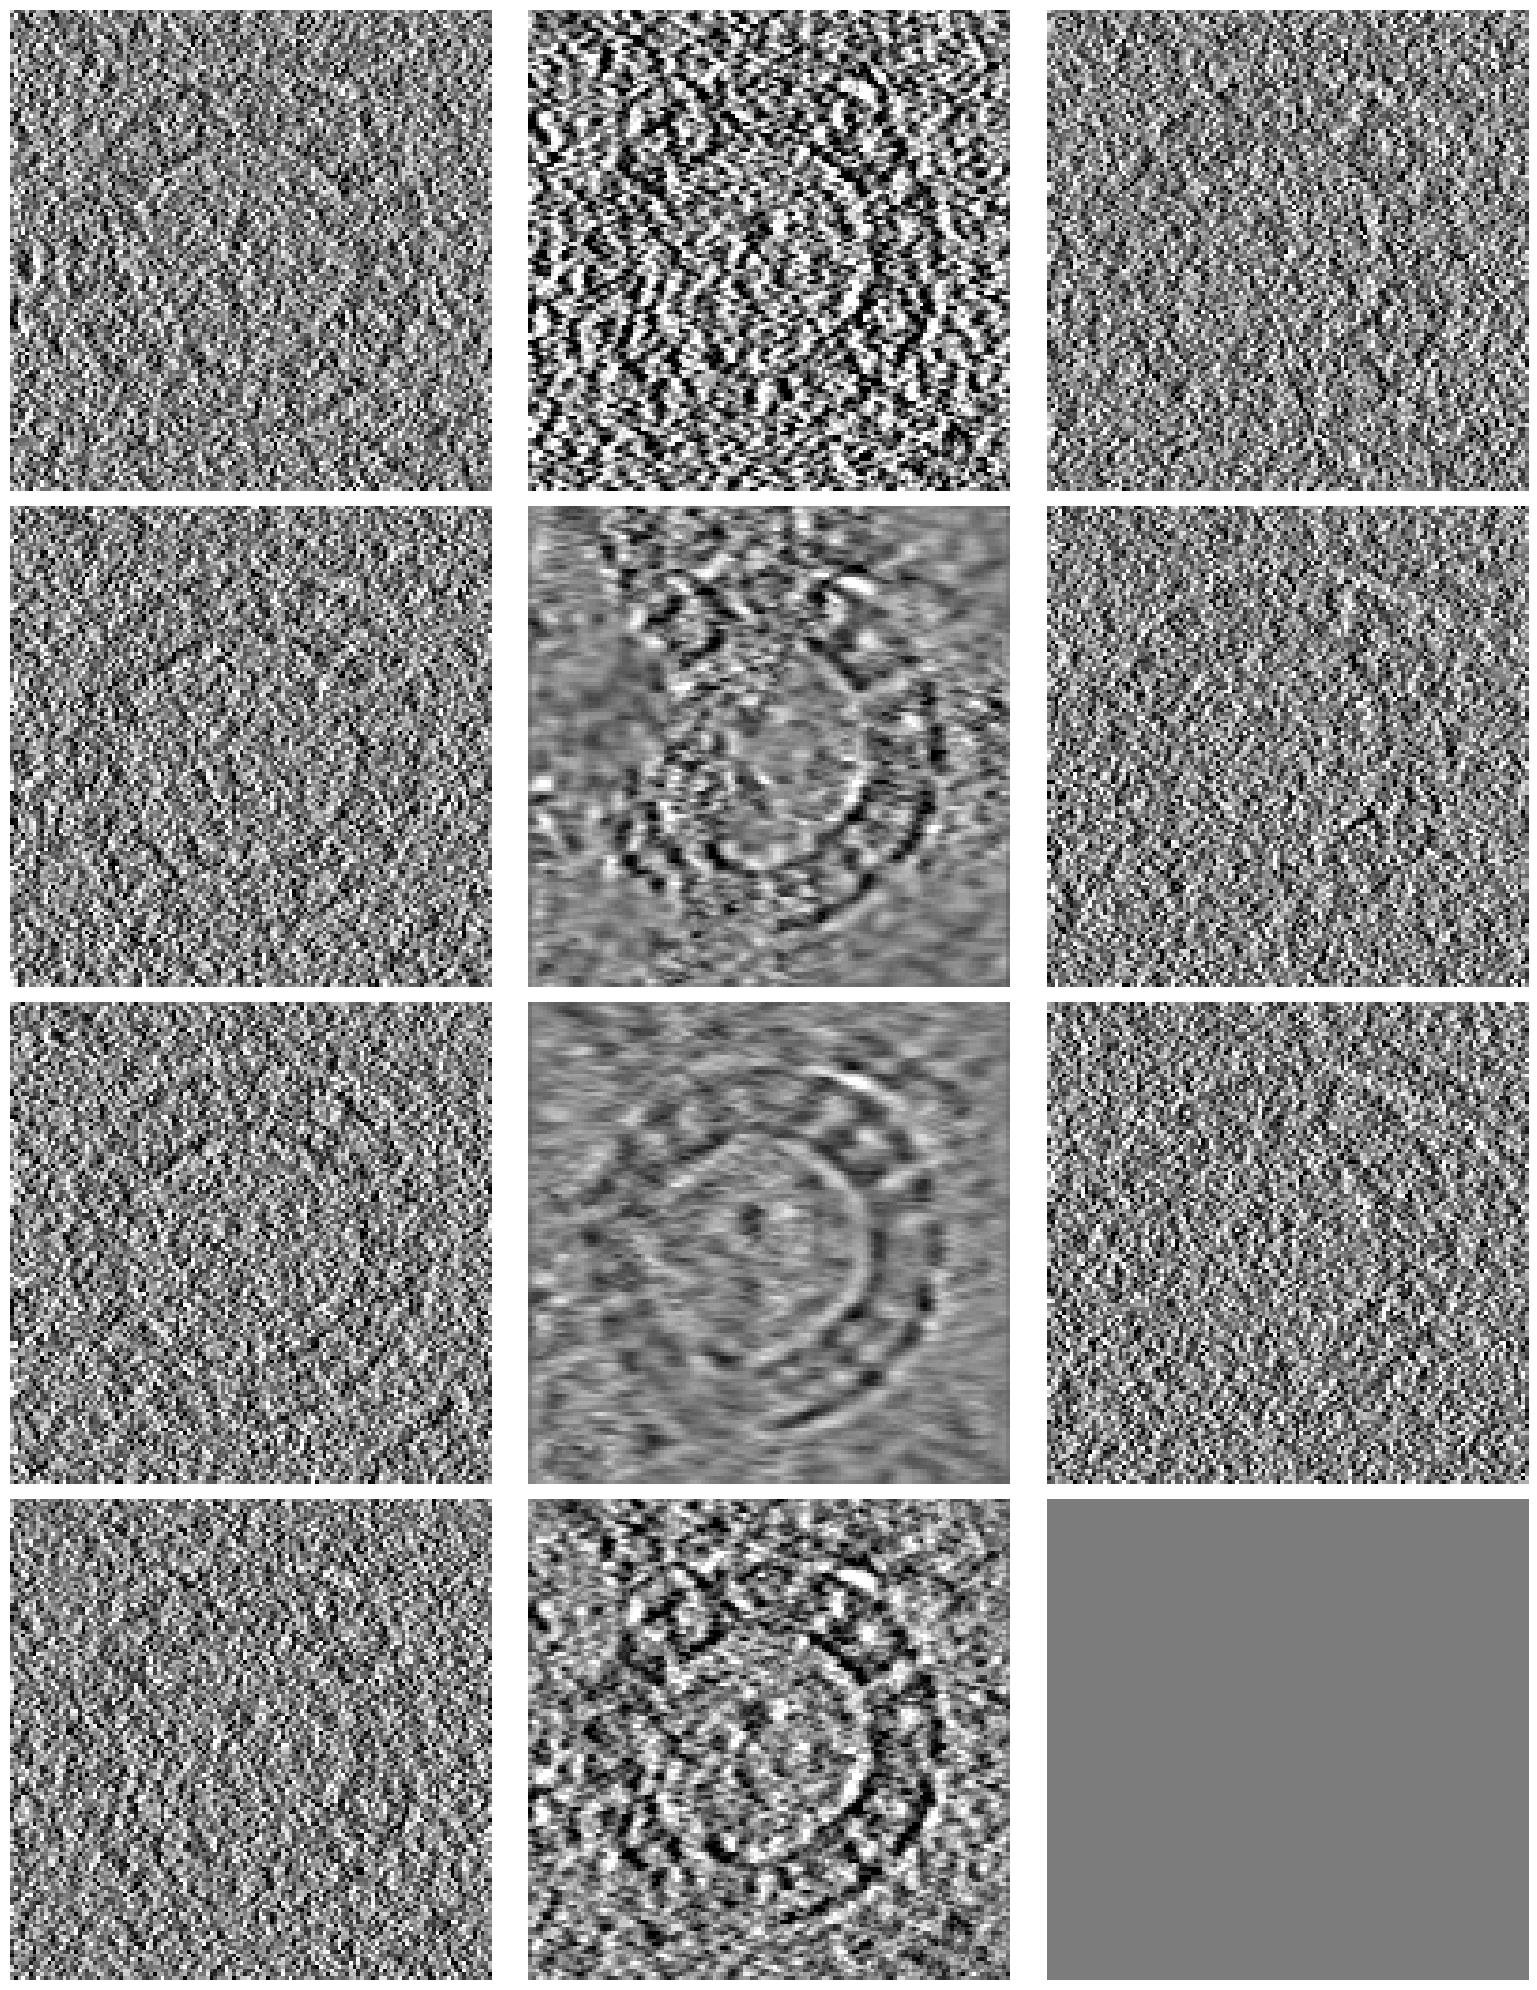

In [45]:
sigma = 2
vmin, vmax = sigma_bounds(crop, sigma=sigma)
vmin_r, vmax_r = sigma_bounds(
    np.repeat(recs, crop.shape[0] // recs.shape[0]), sigma=sigma
)

denoised = recs.mean(axis=0)
vmin_d, vmax_d = sigma_bounds(np.repeat(denoised, crop.shape[0]), sigma=sigma)

plt.figure(figsize=(16, 20))
for i in range(len(triplets)):
    rec, imgs = recs[i], triplets[i]
    plt.subplot(len(triplets) + 1, 3, 3 * i + 1)
    plt.imshow(imgs[0], cmap="grey", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.subplot(len(triplets) + 1, 3, 3 * i + 2)
    plt.imshow(rec, cmap="grey", vmin=vmin_r, vmax=vmax_r)
    plt.axis("off")
    plt.subplot(len(triplets) + 1, 3, 3 * i + 3)
    plt.imshow(imgs[2], cmap="grey", vmin=vmin, vmax=vmax)
    plt.axis("off")
plt.subplot(len(triplets) + 1, 3, 10)
plt.imshow(triplets[0][1], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.subplot(len(triplets) + 1, 3, 11)
plt.imshow(denoised, cmap="grey", vmin=vmin_d, vmax=vmax_d)
plt.axis("off")
plt.subplot(len(triplets) + 1, 3, 12)
plt.imshow(recs[0] - recs[0], cmap="grey", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.tight_layout()
# plt.savefig('fig1_E.svg', format='svg')
plt.show()